## 시퀀스 모델을 위한 합성곱 신경망과 순환 신경망
#### 시퀀스 데이터를 위한 합성곱

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1D 합성곱 만들기
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """기간마다 동일한 패턴을 반복합니다"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# 시계열을 만듭니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 잡음을 추가합니다.
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

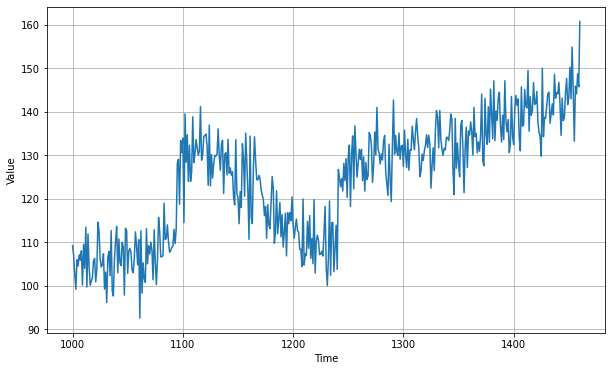

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
31/31 [==============================] - 3s 28ms/step - loss: 698.0324
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 111.1634
Epoch 3/100
31/31 [==============================] - 1s 8ms/step - loss: 86.4694
Epoch 4/100
31/31 [==============================] - 1s 8ms/step - loss: 76.1439
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 70.7931
Epoch 6/100
31/31 [==============================] - 1s 9ms/step - loss: 68.4922
Epoch 7/100
31/31 [==============================] - 1s 8ms/step - loss: 68.4821
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 67.4384
Epoch 9/100
31/31 [==============================] - 1s 9ms/step - loss: 65.9891
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 66.7022
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 65.9637
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 66.1107
Epoch 13/100
31/31 [==

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 0s 5ms/step


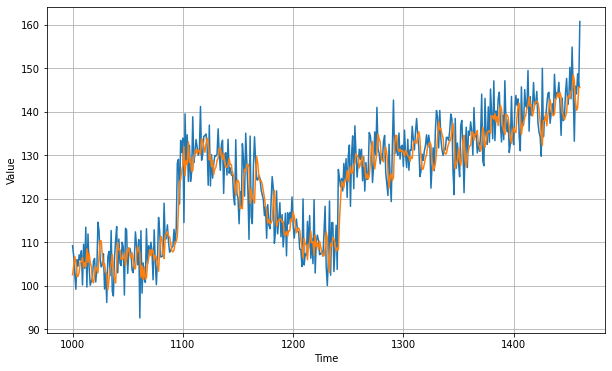

In [8]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.627046

In [11]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.9 MB/s eta 0:00:00


In [12]:
from keras_tuner.tuners import RandomSearch

In [13]:
# Conv1D 하이퍼 파라미터 튜닝하기

def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                     kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                     strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                     padding='causal', activation='relu', input_shape=[None, 1]))

    model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    sgd = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-5)
    model.compile(loss="mse", optimizer=sgd)
    return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, 
                     executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 27 Complete [00h 01m 41s]
loss: 61.466845194498696

Best loss So Far: 59.696475982666016
Total elapsed time: 00h 49m 48s


In [14]:
tuner.results_summary()

Results summary
Results in my_dir/cnn-tune
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
Score: 59.696475982666016
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 59.86846160888672
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 59.966940561930336
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 59.99919637044271
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
Score: 60.011905670166016
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 60.11902618408203
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
Score: 61.466845194498696
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 61.479286193847656
Trial summary
Hyperparameters:
units: 256
kernels: 3
strides: 1
Score: 61.49980799357096
Trial summary
Hyperparameters:
units: 128
kernels: 3
strides: 1
Score: 61.52316411336263


In [15]:
best_model = tuner.get_best_models(num_models=1)[0]

In [16]:
forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 0s 6ms/step


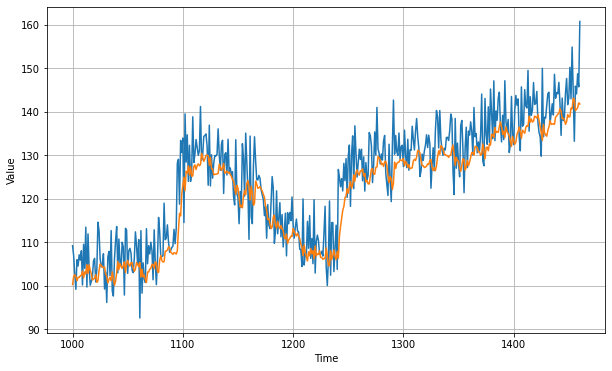

In [17]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.110979

#### NASA 날씨 데이터 사용하기

In [19]:
!wget https://storage.googleapis.com/learning-datasets/station.csv

--2023-03-24 11:42:24--  https://storage.googleapis.com/learning-datasets/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘station.csv’

station.csv         100%[===================>]   6.82K  --.-KB/s    in 0s      

2023-03-24 11:42:24 (46.7 MB/s) - ‘station.csv’ saved [6979/6979]



In [20]:
def get_station_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))
    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [21]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [22]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [23]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size,
                                 batch_size, shuffle_buffer_size)

#### RNN으로 시퀀스 모델링하기

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True,
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

In [25]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, verbose=1,
                    validation_data=valid_dataset)

Epoch 1/100
64/64 [==============================] - 3s 24ms/step - loss: 0.6278 - mae: 1.0629 - val_loss: 0.6283 - val_mae: 1.0794
Epoch 2/100
64/64 [==============================] - 3s 40ms/step - loss: 0.5283 - mae: 0.9542 - val_loss: 0.5248 - val_mae: 0.9647
Epoch 3/100
64/64 [==============================] - 2s 28ms/step - loss: 0.4327 - mae: 0.8457 - val_loss: 0.4314 - val_mae: 0.8538
Epoch 4/100
64/64 [==============================] - 2s 28ms/step - loss: 0.3471 - mae: 0.7434 - val_loss: 0.3511 - val_mae: 0.7515
Epoch 5/100
64/64 [==============================] - 2s 31ms/step - loss: 0.2749 - mae: 0.6506 - val_loss: 0.2842 - val_mae: 0.6585
Epoch 6/100
64/64 [==============================] - 2s 27ms/step - loss: 0.2170 - mae: 0.5690 - val_loss: 0.2310 - val_mae: 0.5768
Epoch 7/100
64/64 [==============================] - 3s 40ms/step - loss: 0.1728 - mae: 0.5005 - val_loss: 0.1895 - val_mae: 0.5065
Epoch 8/100
64/64 [==============================] - 2s 30ms/step - loss: 0.

In [26]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 0s 29ms/step


In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.26361844

In [29]:
# 대용량 데이터셋 사용하기
!wget https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt

--2023-03-24 11:44:56--  https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1728976 (1.6M) [text/plain]
Saving to: ‘tdaily_cet.dat.txt’

tdaily_cet.dat.txt  100%[===================>]   1.65M  --.-KB/s    in 0.01s   

2023-03-24 11:44:56 (114 MB/s) - ‘tdaily_cet.dat.txt’ saved [1728976/1728976]



In [30]:
def get_tdaily_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [31]:
time, series = get_tdaily_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [32]:
window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(100), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
667/667 [==============================] - 67s 99ms/step - loss: 0.1246 - mae: 0.3960 - val_loss: 0.0997 - val_mae: 0.3549
Epoch 2/100
667/667 [==============================] - 96s 143ms/step - loss: 0.0996 - mae: 0.3523 - val_loss: 0.0873 - val_mae: 0.3316
Epoch 3/100
667/667 [==============================] - 66s 99ms/step - loss: 0.0899 - mae: 0.3344 - val_loss: 0.0799 - val_mae: 0.3170
Epoch 4/100
667/667 [==============================] - 66s 99ms/step - loss: 0.0836 - mae: 0.3222 - val_loss: 0.0746 - val_mae: 0.3062
Epoch 5/100
667/667 [==============================] - 65s 97ms/step - loss: 0.0789 - mae: 0.3129 - val_loss: 0.0705 - val_mae: 0.2976
Epoch 6/100
667/667 [==============================] - 64s 96ms/step - loss: 0.0752 - mae: 0.3054 - val_loss: 0.0672 - val_mae: 0.2907
Epoch 7/100
667/667 [==============================] - 66s 99ms/step - loss: 0.0723 - mae: 0.2993 - val_loss: 0.0646 - val_mae: 0.2848
Epoch 8/100
667/667 [==============================] -

In [33]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

334/334 [==============================] - 7s 19ms/step


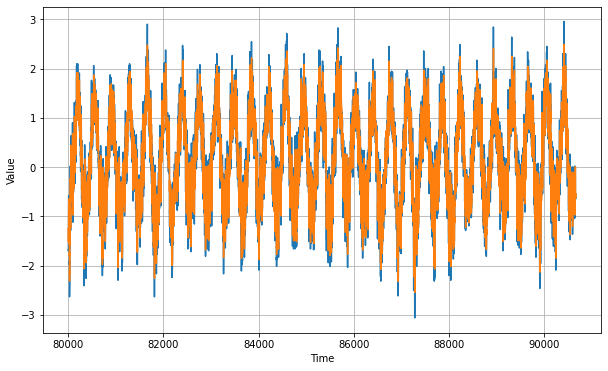

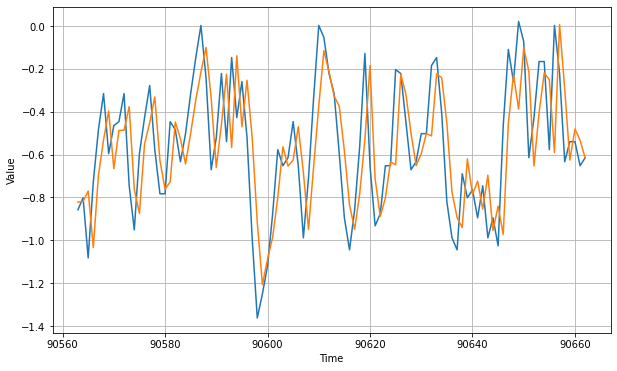

In [34]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.24220823

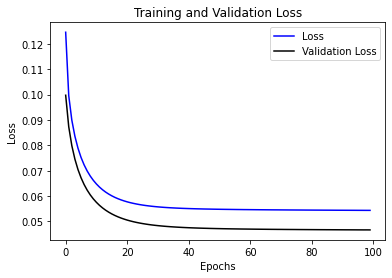

In [36]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

- 정규화했기 때문에 손실과 MAE가 낮아보일 수 있습니다.
- 따라서 0.1보다 작은 손실은 오해의 여지가 있어
- 정규화를 거꾸로 적용해서 확인하는 것도 필요합니다.

#### 다른 순환 층 사용 & 드롭아웃
- A Theoretically Grounded Application of Dropout in Recurrent Neural Networks 참고
- 일반적으로 드롭아웃은 랜덤하지만 tf.keras의 드롭아웃은 위의 논문에서 권장하는 방식을 따릅니다.

In [37]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [38]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [39]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 12s 82ms/step - loss: 0.4494 - mae: 0.8600 - val_loss: 0.4965 - val_mae: 0.9209
Epoch 2/500
64/64 [==============================] - 6s 90ms/step - loss: 0.4471 - mae: 0.8573 - val_loss: 0.4944 - val_mae: 0.9179
Epoch 3/500
64/64 [==============================] - 5s 70ms/step - loss: 0.4448 - mae: 0.8549 - val_loss: 0.4923 - val_mae: 0.9149
Epoch 4/500
64/64 [==============================] - 6s 91ms/step - loss: 0.4434 - mae: 0.8528 - val_loss: 0.4902 - val_mae: 0.9120
Epoch 5/500
64/64 [==============================] - 5s 71ms/step - loss: 0.4399 - mae: 0.8487 - val_loss: 0.4882 - val_mae: 0.9090
Epoch 6/500
64/64 [==============================] - 5s 74ms/step - loss: 0.4387 - mae: 0.8475 - val_loss: 0.4861 - val_mae: 0.9062
Epoch 7/500
64/64 [==============================] - 5s 85ms/step - loss: 0.4362 - mae: 0.8441 - val_loss: 0.4841 - val_mae: 0.9034
Epoch 8/500
64/64 [==============================] - 4s 70ms/step - loss: 0

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

In [ ]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

#### 양방향 RNN 사용하기

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

In [ ]:
# 윈도 크기 늘려보기
window_size = 40
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()